https://steemit.com/kr/@codingart/4-8-imdb-sentiment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from collections import defaultdict
from glob import glob
from bs4 import BeautifulSoup
from lxml import html
import os
import re
import time
import numpy as np
import pandas as pd
import requests
#import utils
import requests
import pandas as pd
import urllib.parse
import time
import torch
import datetime
import random
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dfc615k/ko_sample.csv
/kaggle/input/dfc615k/ko_data.csv
/kaggle/input/data10/ko_data2.csv
/kaggle/input/naverdata22/ko_data.csv
/kaggle/input/naver33/naverfile2.csv
/kaggle/input/naverdata2/naver.csv
/kaggle/input/ratings/ratings_train.txt


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data


In [3]:
data = pd.read_csv("/kaggle/input/dfc615k/ko_data.csv", sep=",", encoding="ms949")
sample = pd.read_csv("/kaggle/input/dfc615k/ko_sample.csv", sep=",", encoding="ms949")
moviecomments = pd.read_csv("/kaggle/input/naverdata2/naver.csv", sep=",")
moviecomments2 = pd.read_csv("/kaggle/input/naver33/naverfile2.csv", sep=",")
ratings = pd.read_csv("/kaggle/input/naver33/naverfile2.csv", sep=",")
ratings_train = read_data('/kaggle/input/ratings/ratings_train.txt')

len(data), len(sample), len(moviecomments), len(moviecomments2), len(ratings_train)

(11187, 11187, 10000, 9990, 150000)

In [4]:
moviecomments = pd.concat([moviecomments, moviecomments2])

In [5]:
moviecomments = moviecomments[moviecomments['POINT'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])]
moviecomments
moviecomments['POINT'] = moviecomments['POINT'].astype(str).astype(int)
moviecomments['Y'] = 0
moviecomments.loc[moviecomments['POINT']>=9, "Y"] = 1
moviecomments.loc[moviecomments['POINT']<=4, "Y"] = 0
moviecomments = moviecomments[moviecomments['Y']>=0]
moviecomments.head()

,Unnamed: 0,ID,TITLE,POINT,COMMENT,Y
0,0,16905147,어쌔신 걸스,1,감독새끼 집주소가 시급하다. 문재인이 지 페북에 쳐올린 근친야동이 더 잼날듯.,0
1,1,16905146,사랑하기 때문에,10,NaN,1
2,2,16905145,셰이프 오브 워터: 사랑의 모양,10,솔직히 좀 불쾌할걸 예상했는데 그럴생각 1도없이 완전히 매료되어버렸다... 그나저나...,1
3,3,16905144,들어는 봤니? 모건 부부,10,오랜만에 넘 재밌게 본 로맨틱코미디 영화네요!뉴욕과 시골을 넘나드는 좀 어이없으면서...,1
4,4,16905143,침입자,1,기대 안하고 봤는데 기대 이하였음..,0


In [6]:
ratings_train = pd.DataFrame(ratings_train, columns=['ID', 'COMMENT', 'Y'])


In [7]:
ratings_train['Y'] = ratings_train['Y'].astype(int)

In [8]:
ratings_train = ratings_train[ratings_train['Y'].isin([1, 0])]

In [9]:
len(ratings_train)

150000

In [10]:
moviecomments = pd.concat([moviecomments[['COMMENT', 'Y']][:10], ratings_train[['COMMENT', 'Y']]])

In [11]:
moviecomments = moviecomments[~moviecomments['COMMENT'].isnull()].reset_index(drop=True)

In [12]:

import cufflinks
cufflinks.go_offline(connected=True)

In [13]:
moviecomments['COMMENT'].value_counts().sort_values(ascending=False)

굿                                                                                                        181
good                                                                                                      92
최고                                                                                                        85
쓰레기                                                                                                       79
별로                                                                                                        66
                                                                                                        ... 
이솜말고 볼게없어서 1점드립니다 ^오^                                                                                      1
중학교때 뭣모르고 영화관가서 봣다가 욕하고 나온영화 최근에 우연히 한번더 보게되었는데 너무 흐름이 뚝뚝끊겨서 내용 전개가 더 어이없었고 도서관 관계씬은 때리고 싶다 배경만 예쁜 영화      1
내가 만들어도 이것보다는 낫겠다                                                                                          1
총이 멋짐              

In [14]:
moviecomments['COMMENT'].value_counts().sort_values(ascending=False)[0:40][40:0:-1].iplot(kind='barh', yTitle='comment', title='Number')

In [15]:
#moviecomments = moviecomments

In [16]:
moviecomments.columns

Index(['COMMENT', 'Y'], dtype='object')

In [17]:
moviecomments = moviecomments[['COMMENT', 'Y']].reset_index(drop=True)

In [18]:
sentences = moviecomments['COMMENT']
sentences[:10]

0         감독새끼 집주소가 시급하다. 문재인이 지 페북에 쳐올린 근친야동이 더 잼날듯. 
1    솔직히 좀 불쾌할걸 예상했는데 그럴생각 1도없이 완전히 매료되어버렸다... 그나저나...
2    오랜만에 넘 재밌게 본 로맨틱코미디 영화네요!뉴욕과 시골을 넘나드는 좀 어이없으면서...
3                                기대 안하고 봤는데 기대 이하였음.. 
4                              그때의 감동 팬들을 생각하는 마음과 교감 
5             다른 세대의 편안한 공감대 뻔한데 그저 흐뭇하다 힐링되는 동화같은 영화 
6                                               ..... 
7                                  아 더빙.. 진짜 짜증나네요 목소리
8                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
9                                    너무재밓었다그래서보는것을추천한다
Name: COMMENT, dtype: object

In [19]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 랭커스터 스태머의 사용
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

# Lemmatization 음소표기법
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [20]:
# 데이터 전처리
def preprocessor(text):
    #특수기호, hTML 태그 등 제거 (단 이모티콘은 남겨둠)
    text = re.sub('[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)|\^.?\^', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

In [21]:
from time import time
import re

stime = time()
sentences = sentences.apply(preprocessor)
moviecomments['WORDS'] = moviecomments['COMMENT'].apply(preprocessor)
moviecomments['WORDS'] = moviecomments['COMMENT'].apply(preprocessor)
data['WORDS'] = data['Sentence'].apply(preprocessor)

print('전처리 처리시간 [%d]'%(time()-stime))


전처리 처리시간 [5]


In [22]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
#stop = stopwords.words('Korean')

def tokenizer(text):
    return text.split()

def  tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()] 


In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import backend as K
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [25]:
tk = Tokenizer(moviecomments['WORDS'], lower=True, split=" ")
tk.fit_on_texts(moviecomments['WORDS'])

In [26]:
# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = nltk.word_tokenize, 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 20000
                            )

In [27]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))


In [28]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(moviecomments['WORDS'], moviecomments['Y'],train_size=0.9, random_state=1, shuffle=False)
x_last = data['WORDS']
X = moviecomments['WORDS']
y = moviecomments['Y']

Text(0.5, 1.0, 'Test')

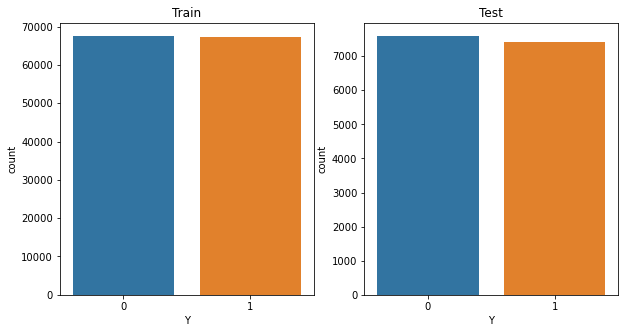

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(10,5)
sns.countplot(y_train, ax=axes[0])
sns.countplot(y_test, ax=axes[1])

# 막대그래프 라벨 
axes[0].set_title("Train", rotation=0)
axes[1].set_title("Test", rotation=0)


In [31]:
train_data_features = pipeline.fit_transform(x_train)
train_data_features.shape

(135006, 20000)

In [32]:
vocab = vectorizer.get_feature_names()

# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[  6 134 178 ...   6   6   6]] &


,&,),0,007,007시리즈,007의,007이,03,04,0개,...,힘듦,힘듬,힘없고,힘없는,힘으로,힘을,힘이,힘이란,힘입어,힛걸
0,6,134,178,54,5,7,8,6,7,8,...,11,20,5,6,15,41,88,6,6,6


In [33]:
train_data_features.shape

(135006, 20000)

In [34]:
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 30, n_jobs = -1, random_state=1)
forest

RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=1)

In [35]:
%%time
traindata = pd.DataFrame(train_data_features.toarray(), columns=vocab)
forest.fit(traindata.values, y_train)

CPU times: user 1h 49min 52s, sys: 11.8 s, total: 1h 50min 4s
Wall time: 29min 33s


RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=1)

In [36]:
%time 
score = np.mean(cross_val_score(forest,
                                train_data_features,
                                y_train,
                                cv=10))
score

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


0.7679361676912821

In [37]:
#test_data_features = pipeline.transform(df_test['words'].values)
test_data_features = pipeline.transform(x_test.values)
test_data_features = test_data_features.toarray()

test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
%time 

score = np.mean(cross_val_score(forest,
                                test_data_features,
                                y_test,
                                cv=10))
score

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


0.7286847435043305

In [39]:
testdata = pd.DataFrame(test_data_features, columns=vocab)
testpredict = forest.predict(testdata.values)

In [40]:
pd.Series(testpredict).value_counts()

1    7945
0    7056
dtype: int64

In [41]:
%%time
last_data_features = pipeline.transform(data['Sentence'].values)
last_data_features = last_data_features.toarray()


CPU times: user 1.62 s, sys: 84.8 ms, total: 1.71 s
Wall time: 1.71 s


In [42]:
%%time
lastdata = pd.DataFrame(last_data_features, columns=vocab)
lastpredict = forest.predict(lastdata.values)

CPU times: user 4.99 s, sys: 407 ms, total: 5.4 s
Wall time: 2.12 s


In [43]:
sample['Predicted'] = lastpredict

In [44]:
sample['Predicted'].value_counts()

1    5859
0    5328
Name: Predicted, dtype: int64

In [45]:
sample['Predicted'] = lastpredict
sample.to_csv("/kaggle/working/result1randomforest2.csv", sep=",", index=False)

단어 벡터화

In [46]:

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 10000
                            )

In [47]:
%%time

pipeline = Pipeline([
    ('vect', vectorizer),
])

train_data_features = pipeline.fit_transform(x_train.values)
vectorizer._validate_vocabulary()
vocab = vectorizer.get_feature_names()

# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 25, n_jobs = -1, random_state=1)
traindata = pd.DataFrame(train_data_features.toarray(), columns=vocab)

# 데이터 학습
print("데이터 학습")
forest.fit(traindata.values, y_train)

score = np.mean(cross_val_score(forest,
                                train_data_features,
                                y_train,
                                cv=10))

# 정확도 출력 
print("정확도 학습")
score

[[ 54  17 123 ...  15  41  88]] 007
데이터 학습
정확도 학습
CPU times: user 1h 9min 19s, sys: 8.44 s, total: 1h 9min 27s
Wall time: 29min 3s


0.7534479799850218

In [48]:
%%time
test_data_features = pipeline.transform(x_test.values)
test_data_features = test_data_features.toarray()
test = pd.DataFrame(test_data_features, columns=vocab)
testpredict = forest.predict(test.values)
score = np.mean(cross_val_score(forest,
                                test_data_features,
                                y_test,
                                cv=10))
score

CPU times: user 12.8 s, sys: 7.66 s, total: 20.5 s
Wall time: 12min 43s


0.7138186098156785

In [49]:
pd.Series(testpredict).value_counts()

1    8101
0    6900
dtype: int64

In [50]:
y_test.value_counts()

0    7594
1    7407
Name: Y, dtype: int64

In [51]:
%%time
last_data_features = pipeline.transform(data['Sentence'].values)
last_data_features = last_data_features.toarray()
lasts = pd.DataFrame(last_data_features, columns=vocab)
lastpredict = forest.predict(lasts.values)

CPU times: user 2.72 s, sys: 274 ms, total: 3 s
Wall time: 1.52 s


In [52]:
pd.Series(lastpredict).value_counts()

1    5878
0    5309
dtype: int64

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pickle

In [54]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)

In [55]:
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(C=10, penalty='l2', random_state=0))])
lr_tfidf.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function tokenizer at 0x7fdd44d42dd0>)),
                ('clf', LogisticRegression(C=10, random_state=0))])

In [56]:
accuracy_score(lr_tfidf.predict(x_train), y_train)

0.9795934995481682

In [57]:
y_pred = lr_tfidf.predict(x_test)
accuracy_score(y_test, y_pred)

0.8285447636824211

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

In [58]:
y_pred[:100]

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [59]:
y_last = lr_tfidf.predict(x_last)
sample['Predicted'] = y_last
sample['Predicted'].value_counts()

1    5635
0    5552
Name: Predicted, dtype: int64

In [60]:
sample[['Id', 'Predicted']].to_csv("/kaggle/working/rancomforest2.csv", sep=",", encoding="ms949", index=False)

In [61]:
종료!!!

SyntaxError: invalid syntax (<ipython-input-61-85870ee83a84>, line 1)